# Computing the Jacobian Matrix at the Equilibrium Point 

In [1]:
using ChebyshevApprox
using DifferentialEquations
using ForwardDiff
using LinearAlgebra
using PyCall
using PyPlot
include("AerodynamicsCoefficients.jl")

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1189


### Simplified Dynamics Model
- We assume flat planet model, gravity acceleration is directed along the x axis.
- We assume constant uniform of the atmosphere.
- We assume that the fluid is static.

In [9]:
r_min = 0.20 # smallest radius of the cone [m]
r_max = 1.30 # largest radius of the cone [m]
l = 0.55 # length of the cone [m]
m = 569.7 # mass of the Phoenix entry system [kg]
x_g = 1.0 #-0.152 # axial center-of-gravity location [m]
order = 10
filename = "chebyshev_coefficients.jld"
save_chebyshev_coefficients_tan(r_max, r_min, l, x_g, order, filename)

In [10]:
## Utilities
"""
@(SIGNATURES)
    Conjuguate of a quaternion. 
"""
function qconj(q)
    p = q
    p[2:4] = - q[2:4]
return p / norm(q)^2
end

"""
@(SIGNATURES)
    Rotate a vector by a quaternion
"""
function qrot(q,r)
    r + 2*cross(q[2:4],cross(q[2:4],r) + q[1]*r)
end

"""
@(SIGNATURES)
    Multiplication of two quaternions (q = [s;v])
"""
function qmult(q1,q2)
    [q1[1]*q2[1] - q1[2:4]'*q2[2:4]; q1[1]*q2[2:4] + q2[1]*q1[2:4] + cross(q1[2:4],q2[2:4])]
end

function entry_vehicle_dynamics!(ẋ,X,u)
    ## States: X ∈ R^13; q = [s;v]
    # x
    # y
    # z
    # q0
    # q1
    # q2
    # q3
    # xdot
    # ydot
    # zdot
    # omega1
    # omega2
    # omega3

    x = X[1:3]
    q = X[4:7]./norm(X[4:7]) #normalize quaternion
    v = X[8:10]
    ω = X[11:13]

    # Parameters
    r_min = 0.20 # smallest radius of the cone [m]
    r_max = 1.30 # largest radius of the cone [m]
    l = 0.55 # length of the cone [m]
    m = 569.7 # mass of the Phoenix entry system [kg]
    x_g = 1.0 #-0.152 # axial center-of-gravity location [m]
    Jxx = 293.15 # Phoenix entry system [kg.m^2]
    Jyy = 184 # Phoenix entry system [kg.m^2]
    Jzz = 208.02 # Phoenix entry system [kg.m^2]
    Jxy = 0.451 # Phoenix entry system [kg.m^2]
    Jxz = -4.424 # Phoenix entry system [kg.m^2]
    Jyz = 0.372 # Phoenix entry system [kg.m^2]
    J = Matrix([Jxx Jxy Jxz; Jxy Jyy Jyz; Jxz Jyz Jzz])# Inertia matrix [kg.m^2]
    Jinv = inv(J) # inverted inertia matrix [kg^-1.m^-2]
    g = 3.711 # Mars gravity [m^2.s^-1]
    h = 10800 # Atmospheric Scale Height [m]
    ρ_0 = 0.020 # Surface density of Mars atmosphere [kg.m^-3]
    r_p = 3389.5e3 # Volumetric mean radius of Mars [m]
    ω_p = [0, 0, 7.088e-05] # Angular velocity of Mars [rad.s^-1]

    # Mars atmosphere model
    altitude = norm(x) - r_p
    # Uniform density assumption
    ρ_inf = ρ_0 * exp(- altitude / h)

    # Freestream Velocity
    # Static fluid assumption
    V_inf = - qrot(qconj(q), v) # - qrot(qconj(q), v + cross(x, ω_p))

    # This rotation matrix includes the 1/tan(α) terms required to rescale the aerodynamics 
    # coefficients C_Y2 and C_n2.
    s_cos_θ = V_inf[2] / V_inf[1]
    s_sin_θ = V_inf[3] / V_inf[1]
    Rot_2_1 = [1 0 0; 0 s_cos_θ -s_sin_θ; 0 s_sin_θ s_cos_θ]
    # Since α ∈ [0, π/2[ we can use atan with one variable, it is differentiable in 0.
    ϵ = 1e-100
    α = atan((sqrt(V_inf[2]^2 + V_inf[3]^2 + ϵ^2) - ϵ)/ V_inf[1])
    
    # Aerodynamic Forces and Moments in Freestream frame
    C_F2, C_τ2 = aerodynamics_coefficents_chebyshev_tan(α, r_max, r_min, l, x_g)

    F_2 = 1.0/2 * ρ_inf * norm(V_inf)^2 * C_F2
    τ_2 = 1.0/2 * ρ_inf * norm(V_inf)^2 * C_τ2

    F_a = Rot_2_1 * F_2
    τ_a = Rot_2_1 * τ_2

    # Control forces and moments in body_frame
    F_c = zeros(3)
    τ_c = zeros(3)

    # Forces and moments in body-frame
    F = F_a + F_c
    τ = τ_a + τ_c
#     println("τ", τ)
#     println("V_inf", V_inf)
#     println("ρ_inf", ρ_inf)
#     println("τ_2", τ_2)
#     println("τ_a", τ_a)
#     println("altitude", altitude)
    
    ẋ[1:3] = v # velocity in world frame
    ẋ[4:7] = 0.5 * qmult(q, [0; ω]) #quaternion derivative
    ẋ[8:10] = +[g, 0, 0] + (1 / m) * qrot(q, F) # -g * x /norm(x) + (1/m)*qrot(q,F) #acceleration in world frame
    ẋ[11:13] = Jinv * (τ - cross(ω , J * ω)) #Euler's equation: I*ω + ω x I*ω = constraint_decrease_ratio
    return ẋ
end

function open_loop_entry_vehicle_dynamics(X::Vector)
    u = zeros(4,1)
    ẋ = X - X
    return entry_vehicle_dynamics!(ẋ,X,u)[1]
end

open_loop_entry_vehicle_dynamics (generic function with 1 method)

## We integrate the dynamics forward to check for the correctness of the model


In [11]:
# Initial conditions
x_0 = -100000.0 - 3389.5e3
x_dot_0 = 1000.0
q_0 = [1, 1, 0.01, 0]
q_0 = q_0 / norm(q_0)
X_0 = [x_0, 0, 0, q_0[1], q_0[2], q_0[3], q_0[4], x_dot_0, 0, 0, 0, 0, 0];

In [12]:
# Dynamics
function open_loop_entry_vehicle_dynamics!(ẋ, X, params, t)
    u = zeros(4,1)
    entry_vehicle_dynamics!(ẋ,X,u)
end

params = []
tspan = (0.0,80.0)
prob = ODEProblem(open_loop_entry_vehicle_dynamics!, X_0,tspan, params)
sol = solve(prob, abstol=1e-8,reltol=1e-8, saveat=0.1);

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/simon/.julia/packages/DiffEqBase/cp0Wf/src/integrator_interface.jl:156


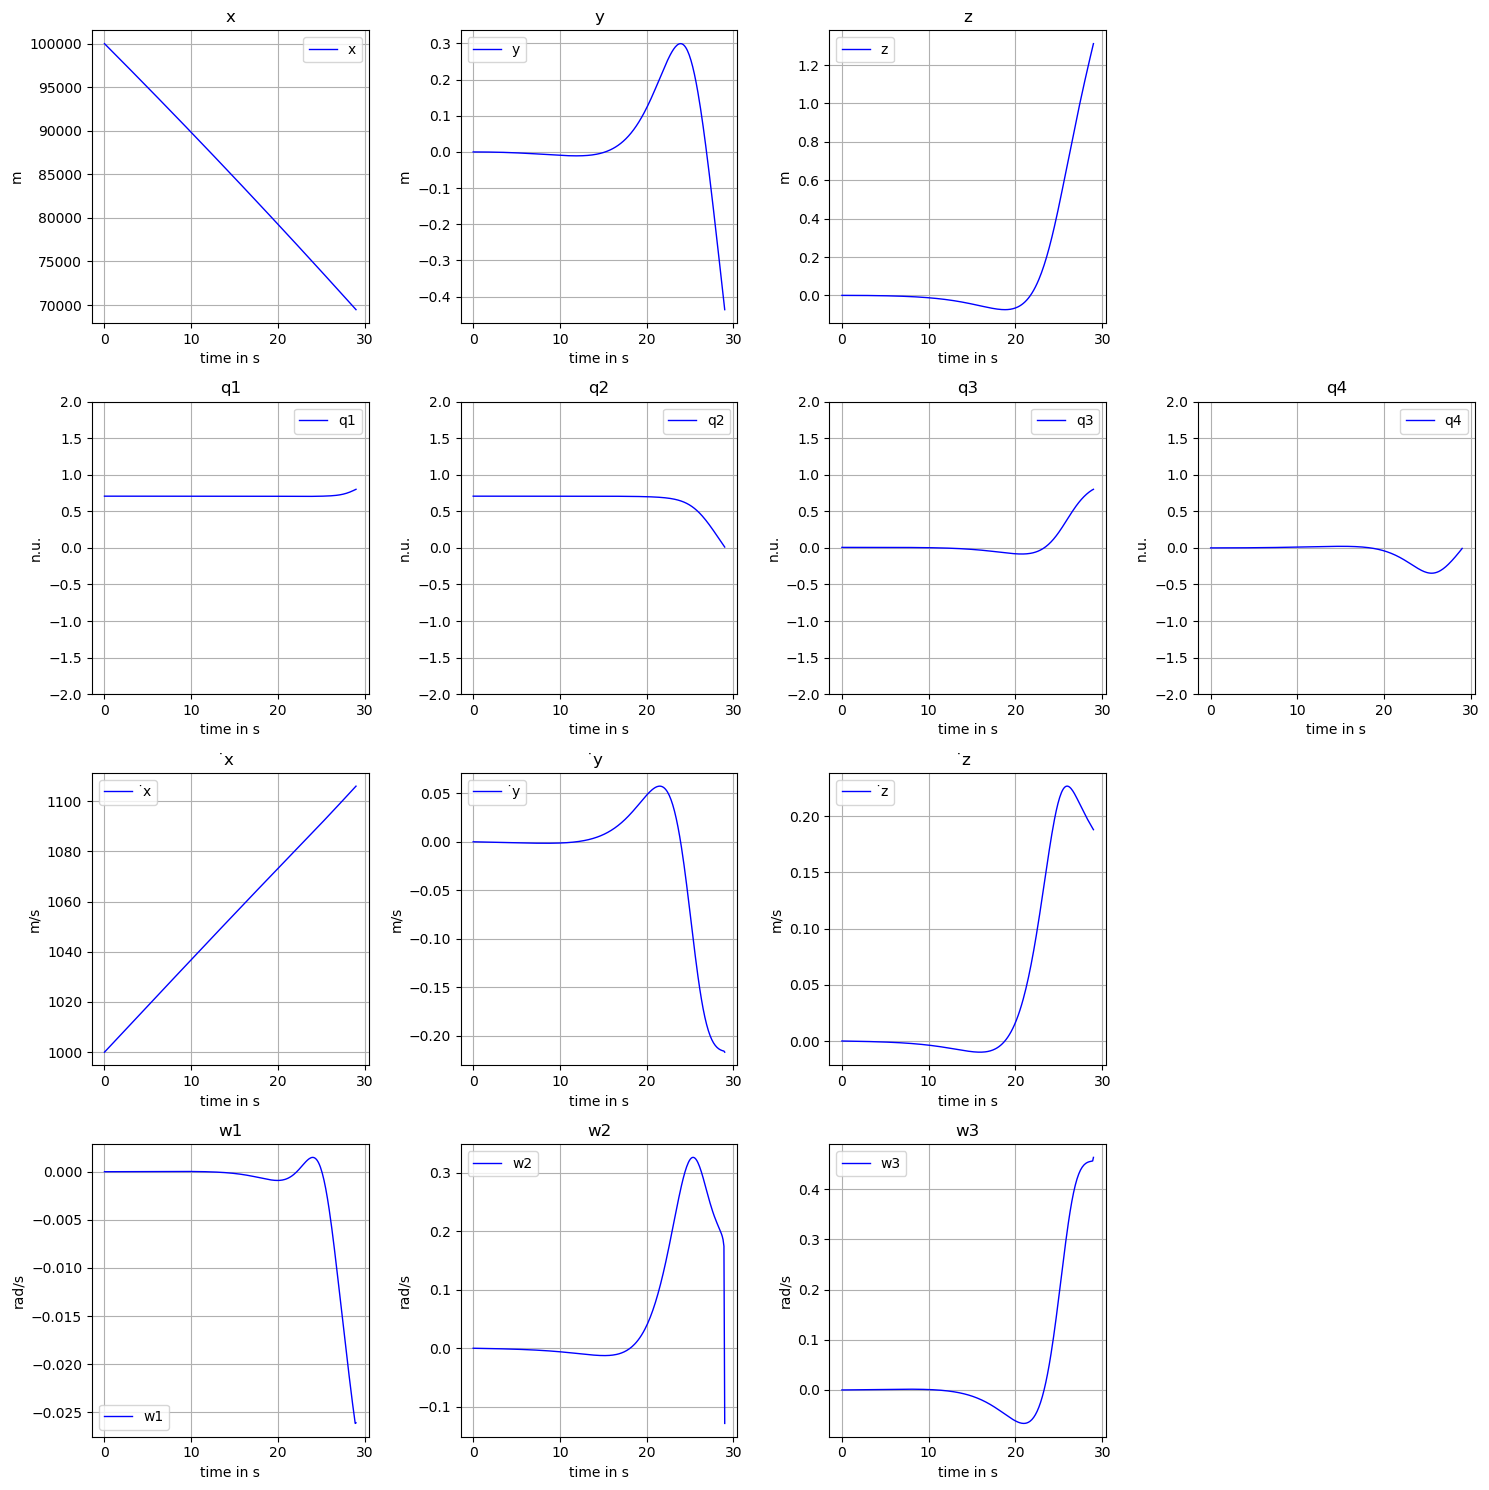

In [13]:
function plot_integrated_dynamics(sol, r_p; display=true)
    figure(figsize=(15,15))
    X_sol = hcat(sol.u...)'
    t_sol = sol.t
#     v = X_sol[:, 8:10]
#     q = X_sol[:, 4:7]
#     V_inf = - qrot.(qconj.(q), v) 
#     α = atan.(sqrt.(V_inf[2]^2 + V_inf[3]^2) ./ V_inf[1])
#     println("size(X_sol)", size(X_sol))
    
    labels = ["x", "y", "z", "q1", "q2", "q3", "q4", "̇x", "̇y", "̇z", "w1", "w2", "w3"]
    units = ["m", "m", "m", "n.u.", "n.u.", "n.u.", "n.u.", "m/s", "m/s", "m/s", "rad/s", "rad/s", "rad/s"]
    indexes = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
    y_lims = [nothing, nothing, nothing, (-2, 2), (-2, 2), (-2, 2), (-2, 2), 
              nothing, nothing, nothing, nothing, nothing, nothing]
    for i=1:length(labels)
        Y_sol = X_sol[:, i]
        if labels[i] == "x"
            Y_sol = abs.(X_sol[:, i]) .- r_p 
        end
        subplot(4, 4, indexes[i])
        plot(t_sol, Y_sol, color="blue", linewidth=1.0, 
            linestyle="-", label=labels[i])
        legend()
        title(labels[i])
        grid("on")
        xlabel("time in s")
        ylabel(units[i])
        ylim(y_lims[i])     # set the ylim to bottom, top
    end
    if display
        tight_layout() 
        show()
    end
    return
end

r_p = 3389.5e3 # Volumetric mean radius of Mars [m]
plot_integrated_dynamics(sol, r_p)